## Metrics and Signatures for Meuse models

### Overview

Models: 
- MTS-LSTM Era5 forcing, HydroMT statics (model 1A), trained on US data, tested in Meuse: no static input
- MTS-LSTM Era5 forcing, HydroMT statics (model 1A), trained on US data, tested in Meuse: less static input attributes than in initally trained model

Results
- Load wflow daily and hourly results for Meuse catchments
- Load US model results for Meuse catchments
- Load observed streamflow
- Load forcing precipitation timeseries

Plot: 
- timeseries plots for all Meuse catchments

Metrics:
- Load/Calculate peak metrics
- Load metrics and combine with peak metrics

Signatures:
- Load/Calcualte signatures

Comparison:
- Table with mean metrics and sigantures per model, per catchment
- Corellation between signatures based on observed streamflow and modeled streamflow

Flow duratino curves
- normal
- log 

### Imports etc

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from pandas.plotting import autocorrelation_plot, scatter_matrix

import os
import pickle
from collections import defaultdict
from typing import List, Dict, Tuple
from tqdm.notebook import tqdm
from pathlib import Path

from scipy.stats import pearsonr

from neuralhydrology.evaluation.signatures import calculate_signatures, get_available_signatures
from neuralhydrology.evaluation.metrics import calculate_metrics

from peak_magnitude import mean_peak_magnitude

In [29]:
meuse_dir = 'data/Meuse/'
models = ['lstm_no_stats', 'lstm_less_stats', 'obs'] 

### Data loading
#### load wflow results daily

In [6]:
frequencies = ['1D', '1H']

# observations reach from 2005 until 2018
# start_date = pd.to_datetime('1981-01-01', format='%Y-%m-%d')   # for simulations
start_date = pd.to_datetime('2005-10-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2017-09-30', format='%Y-%m-%d')

catchment_ids_wflow = ['Q_6', 'Q_13', 'Q_701', 'Q_702', 'Q_703'] # , 'Q_1013'
catchment_ids_obs = [6, 13, 701, 702, 703] # 1013 (FR)

areas = [551.65, 305.82, 162.81, 232.15, 123.91] #, 405.49

In [8]:
# wflow predictions in m3/s
wflow_meuse_sim_d = pd.read_csv('data/Meuse/wflow_output_daily.csv', index_col='time')
wflow_meuse_sim_d = wflow_meuse_sim_d[catchment_ids_wflow] 
# wflow_meuse_sim_d.head()

In [9]:
# df to xarray ds
datasets = []
for catchm in wflow_meuse_sim_d.columns:
    df = wflow_meuse_sim_d.filter([catchm], axis=1)
    ds = xr.Dataset.from_dataframe(df)
    ds = ds.rename({catchm: 'Qsim_m3s'})
    ds['catchments'] = int(catchm.split('_')[-1])
    datasets.append(ds)
    
wflow_sim_d = xr.concat(datasets, dim="catchments")
wflow_sim_d['time'] = pd.to_datetime(wflow_sim_d.time.values)
wflow_sim_d = wflow_sim_d.sel(time=slice(start_date, end_date))

# wflow_sim_d

<xarray.Dataset>
Dimensions:     (catchments: 5, time: 4383)
Coordinates:
  * time        (time) datetime64[ns] 2005-10-01 2005-10-02 ... 2017-09-30
  * catchments  (catchments) int64 6 13 701 702 703
Data variables:
    Qsim_m3s    (catchments, time) float64 1.044 1.216 1.469 ... 0.3519 0.3659

#### load wflow results hourly

In [10]:
# wflow predictions in m3/s
wflow_meuse_sim_h = pd.read_csv('data/Meuse/wflow_output_hourly.csv', index_col='time')
wflow_meuse_sim_h = wflow_meuse_sim_h[catchment_ids_wflow]
# wflow_meuse_sim_h.head()

In [11]:
# df to xarray ds
datasets = []
for catchm in wflow_meuse_sim_h.columns:
    df = wflow_meuse_sim_h.filter([catchm], axis=1)
    ds = xr.Dataset.from_dataframe(df)
    ds = ds.rename({catchm: 'Qsim_m3s'})
    ds['catchments'] = int(catchm.split('_')[-1])
    datasets.append(ds)
    
wflow_sim_h = xr.concat(datasets, dim="catchments")
wflow_sim_h['time'] = pd.to_datetime(wflow_sim_h.time.values)
wflow_sim_h = wflow_sim_h.sel(time=slice(start_date, end_date))

# wflow_sim_h

#### load Meuse observations

In [15]:
# Meuse observations in m3/s - HOURLY - BELGIAN CATCHMENTS
meuse_obs_h = xr.open_dataset('data/Meuse/qobs_hourly_belgian_catch.nc')
meuse_obs_h  = meuse_obs_h.sel({'catchments': catchment_ids_obs})
meuse_obs_h = meuse_obs_h.sel(time=slice(start_date, end_date))

# Meuse observations in m3/s - DAILY - BELGIAN CATCHMENTS
meuse_obs_d = meuse_obs_h.resample(time='1D').mean()

# meuse_obs_d
# meuse_obs_h

#### load Meuse US MTS-LSTM results (daily and hourly)
from model with no statics and with less statics
(initial model with all static attribtues gave shifted and scaled streamflow timeseries comapred to observed timeseries) 

In [16]:
# Q in mm/h
with open('data/results/03_era5_hydromt_nostatics/test_results_europe.p', 'rb') as f:
    nostat = pickle.load(f)
with open('data/results/03_era5_hydromt_lessstatics/test_results_europe.p', 'rb') as f:
    lessstat = pickle.load(f)
nostat['meuse_6']['1D'].keys()

dict_keys(['xr', 'NSE_1D', 'KGE_1D', 'RMSE_1D', 'FHV_1D', 'Peak-Timing_1D'])

### Load forcing precipitation time-series for Meuse catchments
required to caluclate runoff ratio and baseflow signature

In [25]:
data_dir = 'data/time-series/Meuse/'
datasets = []
for catchment in catchment_ids_obs:
    ds = xr.open_dataset(data_dir + 'meuse_' + str(catchment) + '.nc')
    datasets.append(ds)
forcing_ds_era5 = xr.concat(datasets, dim='basin')
forcing_ds_era5 = forcing_ds_era5.drop_vars('spatial_ref')

precip_era5 = forcing_ds_era5.precip
precip_era5 = precip_era5.rename({'date': 'datetime'})
# precip_era5

### Plots
#### plotting wflow sim, lstm sim and meuse obs together

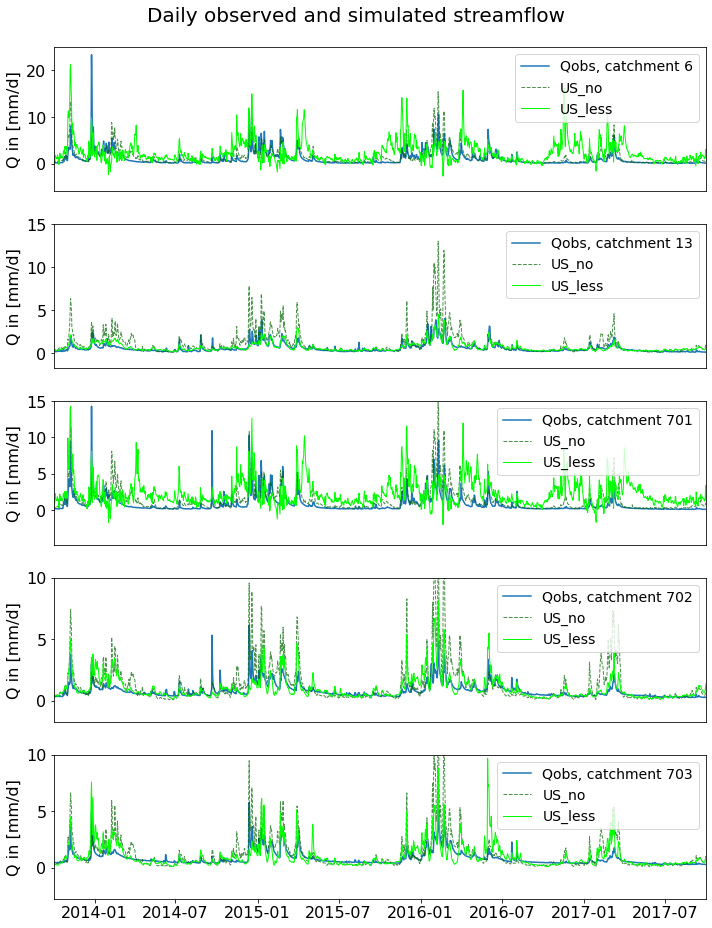

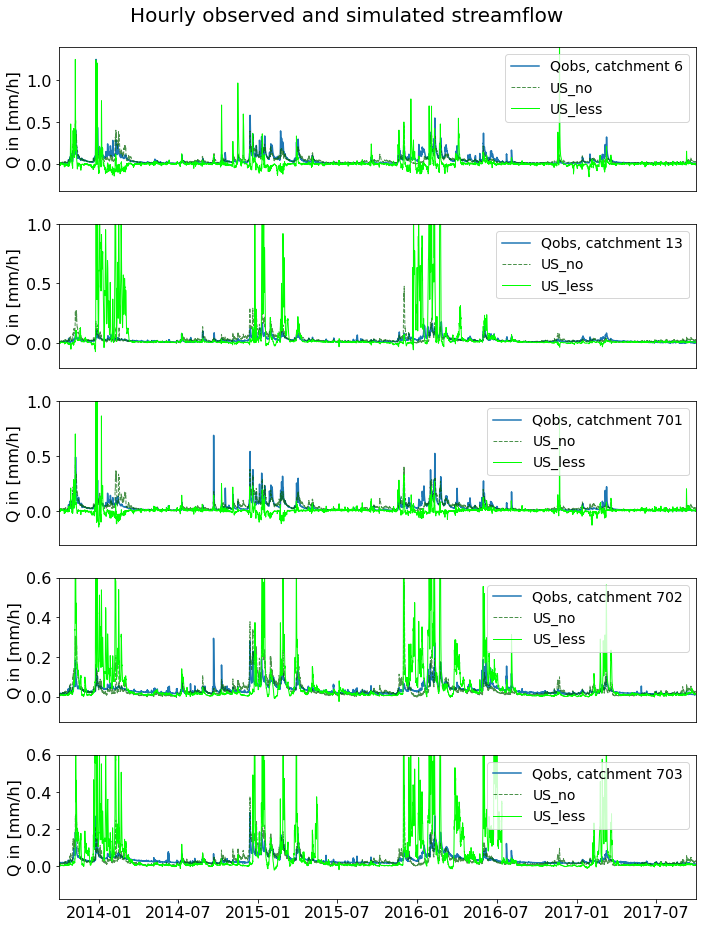

In [17]:
## Q in m3/s/m2 to mm/d by "m3/s/m2 / 10**6 m2/mm2 * 1000 mm/m * 3600 s/h = mm/h * 24 h/d = mm/d"

ylims = [25, 15, 15, 10, 10]
ylims_h = [1.4, 1, 1, 0.6, 0.6]

for freq in frequencies:
        
    fig, axes = plt.subplots(figsize=(10, 15), sharex=True)
    
    if freq == '1D':
        meuse_obs = meuse_obs_d
        wflow_sim = wflow_sim_d
        title = 'Daily observed and simulated streamflow'
    elif freq == '1H':
        meuse_obs = meuse_obs_h
        wflow_sim = wflow_sim_h
        title = 'Hourly observed and simulated streamflow'
        
    for i, catchm in enumerate(meuse_obs.catchments.values):        
        ax = plt.subplot(6, 1, i+1)
        
        # meuse obs
        qobs = meuse_obs.sel({'catchments':catchm}).\
                Qobs_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)
        x = meuse_obs.time.values
        ax.plot(x, qobs, label=f'Qobs, catchment {catchm}')
        
        # wflow sim
#         qsim_w = wflow_sim.sel({'catchments':catchm}).\
#                 Qsim_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)
#         x = wflow_sim.time.values
#         ax.plot(x, qsim_w, label=f'Q_{catchm}_no_stats', alpha=0.7)
        
        # no statics sim
        catchment = 'meuse_' + str(catchm)
        ds = nostat[catchment][freq]['xr']
        if freq == '1H':
            ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
            ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
            ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
        elif freq == '1D':
            ds = ds.isel(time_step = -1)
            ds = ds.drop('time_step')
            ds = ds.rename({'date': 'datetime'})
        qsim_l = ds['qobs_sim'] * (24 if freq == '1D' else 1)
        x = qsim_l.datetime.values
        ax.plot(x, qsim_l, label=f'US_no', color='darkgreen', alpha=0.7, lw=1, ls='--')
        
        # less statics sim
        catchment = 'meuse_' + str(catchm)
        ds = lessstat[catchment][freq]['xr']
        if freq == '1H':
            ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
            ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
            ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
        elif freq == '1D':
            ds = ds.isel(time_step = -1)
            ds = ds.drop('time_step')
            ds = ds.rename({'date': 'datetime'})
        qsim_l = ds['qobs_sim'] * (24 if freq == '1D' else 1)
        x = qsim_l.datetime.values
        ax.plot(x, qsim_l, label=f'US_less', color='lime', alpha=1, lw=1, ls='-')
        
        plt.legend(fontsize=14)
        ax.set_title('')
        ax.set_ylabel('Q in [mm/d]' if freq=='1D' else 'Q in [mm/h]', fontsize=16)
        ax.set_xlim(left=pd.to_datetime('2013-10-01', format='%Y-%m-%d'), right=pd.to_datetime('2017-09-30', format='%Y-%m-%d'))
        ax.set_ylim(top=ylims[i] if freq == '1D' else ylims_h[i])
        
        if i < 4:
            ax.tick_params(labelcolor='none', axis='x', which='both', top=False, bottom=False, left=False, right=False)
            ax.get_xaxis().set_visible(False)
        ax.tick_params('both', labelsize=16)
            
            
    plt.suptitle(title, size=20, y=1)
    plt.tight_layout()
    plt.savefig(f'plots/time-series/meuse_no_less_statics_{freq}')
    plt.show()
    

### Load or calculate metrics
- nested dictionarry: DICT[model][catchment_ID][freq]
    - model: lstm_no_stats, lstm_less_stats  
    - catchment_ID: 6, 13, 701, 702, 703
    - freq: 1D, 1H
    - gives dataframe with metrics as columns: NSE, KGE, Pearson-r, FHV, Peak-Timing, abs_error, rel_error, peaks, sim<obs, sim>obs  


- set repeat to true if you want to recalculate the metrics, otherwise metrics are loaded from pickle file
- to also recalculate metrics for wflow-sbm in Meuse catchments, use code that is commented out

In [22]:
metrics = ['NSE', 'KGE', 'FHV', 'Peak-Timing']

repeat = False
if not os.path.isfile(meuse_dir + '/metrics_stats.p') or repeat == True:
    metrics_dict = defaultdict(lambda: defaultdict(dict))

    for freq in frequencies:

        if freq == '1D':
            meuse_obs = meuse_obs_d
#             wflow_sim = wflow_sim_d
        elif freq == '1H':
            meuse_obs = meuse_obs_h
#             wflow_sim = wflow_sim_h

        for i, catchm in enumerate(catchment_ids_obs):
            print(catchm)
            
            # get simulated streamflow MTS-LSTM no statics
            catchment = 'meuse_' + str(catchm)
            ds = nostat[catchment][freq]['xr']
            if freq == '1H':
                ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
                ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
                ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
            elif freq == '1D':
                ds = ds.isel(time_step = -1)
                ds = ds.drop('time_step')
                ds = ds.rename({'date': 'datetime'})
            qsim_ln = ds['qobs_sim'] * (24 if freq == '1D' else 1)
            qobs_ln = ds['qobs_obs'] * (24 if freq == '1D' else 1)
            
            
            # get simulated streamflow MTS-LSTM less statics
            catchment = 'meuse_' + str(catchm)
            ds = lessstat[catchment][freq]['xr']
            if freq == '1H':
                ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
                ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
                ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
            elif freq == '1D':
                ds = ds.isel(time_step = -1)
                ds = ds.drop('time_step')
                ds = ds.rename({'date': 'datetime'})
            qsim_ll = ds['qobs_sim'] * (24 if freq == '1D' else 1)
            qobs_ll = ds['qobs_obs'] * (24 if freq == '1D' else 1)
            
#             # get simulated streamflow
#             qsim = wflow_sim.sel({'catchments':catchm})['Qsim_m3s']
#             qsim = qsim.sel(time=slice(pd.to_datetime('2013-10-01', format='%Y-%m-%d'), None))
#             qsim = qsim.rename({'time': 'datetime'})

            # get observed streamflow
            qobs = meuse_obs.sel({'catchments':catchm})['Qobs_m3s']
            qobs = qobs.sel(time=slice(pd.to_datetime('2013-10-01', format='%Y-%m-%d'), None))
            qobs = qobs.rename({'time': 'datetime'})

            # convert to mm/h   ---   m3/s * 10**3 mmm/m * 3600 s/h / (10**6 * area)
            area = areas[i]
#             qsim = qsim * 10**3 * 3600 / (area * 10**6)
            qobs = qobs * 10**3 * 3600 / (area * 10**6)

            # calculate metrics    
#             metrics_w = calculate_metrics(qobs, qsim, metrics=metrics, resolution=freq)
#             df_w = pd.DataFrame(data=metrics_w, 
#                                     columns=list(metrics_w.keys()),
#                                     index=[catchm])
            metrics_ln = calculate_metrics(qobs_ln, qsim_ln, metrics=metrics, resolution=freq)
            df_ln = pd.DataFrame(data=metrics_ln, 
                                    columns=list(metrics_ln.keys()),
                                    index=[catchm])
            metrics_ll = calculate_metrics(qobs_ll, qsim_ll, metrics=metrics, resolution=freq)
            df_ll = pd.DataFrame(data=metrics_ll, 
                                    columns=list(metrics_ll.keys()),
                                    index=[catchm])
            
            # calculate peak metrics
#             peak_wflow = mean_peak_magnitude(qobs, qsim, resolution=freq)
#             df_peak_w = pd.DataFrame(data=peak_wflow, 
#                                     columns=['abs_error', 'rel_error', 'peaks', 'sim<obs', 'sim>obs'],
#                                     index=[catchm])
            peak_ln = mean_peak_magnitude(qobs_ln, qsim_ln, resolution=freq)
            peak_ll = mean_peak_magnitude(qobs_ll, qsim_ll, resolution=freq)
            df_peak_ln = pd.DataFrame(data=peak_ln, 
                                    columns=['abs_error', 'rel_error', 'peaks', 'sim<obs', 'sim>obs'],
                                    index=[catchm])
            df_peak_ll = pd.DataFrame(data=peak_ll, 
                                    columns=['abs_error', 'rel_error', 'peaks', 'sim<obs', 'sim>obs'],
                                    index=[catchm])
#             df_w = df_w.join(other=df_peak_w)
            df_ln = df_ln.join(other=df_peak_ln)
            df_ll = df_ll.join(other=df_peak_ll)
            
#             metrics_dict['wflow'][catchm][freq] = df_w 
            metrics_dict['lstm_no_stats'][catchm][freq] = df_ln
            metrics_dict['lstm_less_stats'][catchm][freq] = df_ll
            
    # save to local drive
    pickle.dump({k: dict(v) for k, v in metrics_dict.items()}, Path(meuse_dir + '/metrics_stats.p').open('wb'))
    print('Calculated metrics and stored in pickle file on drive.')
    metrics_dict
else:
    # load from local drive
    metrics_dict = pickle.load(Path(meuse_dir + '/metrics_stats.p').open('rb'))
    print('Loaded metrics pickle file from drive')

# metrics_dict

Loaded metrics pickle file from drive


In [23]:
# example
metrics_dict['lstm_no_stats'][6]['1D']   

,NSE,KGE,Pearson-r,FHV,Peak-Timing,abs_error,rel_error,peaks,sim<obs,sim>obs
6,0.480718,0.637252,0.767046,12.030649,0.538462,3.847322,0.396917,26,19,7


### Load or calculate Signatures
- nested dictionarry: DICT[model][catchment_ID][freq][signature]
    - model: obs, lstm_no_stats, lstm_less_stats   (str)
    - catchment_ID: 6, 13, 701, 702, 703 (int)
    - freq: 1D, 1H (str)
    - signature: 'high_q_freq', 'high_q_dur', 'low_q_freq', 'low_q_dur', 'zero_q_freq', 'q95', 'q5', 'q_mean', 'hfd_mean', 'slope_fdc', 'stream_elas', 'runoff_ratio'


- set repeat to true if you want to recalculate the signatures, otherwise signatures are loaded from pickle file
- to also recalculate signatures for wflow-sbm in Meuse catchments, use code that is commented out

In [24]:
all_signatures = get_available_signatures()
all_signatures.remove('baseflow_index')

all_signatures

['high_q_freq',
 'high_q_dur',
 'low_q_freq',
 'low_q_dur',
 'zero_q_freq',
 'q95',
 'q5',
 'q_mean',
 'hfd_mean',
 'slope_fdc',
 'stream_elas',
 'runoff_ratio']

In [27]:
repeat=False
if not os.path.isfile(meuse_dir + '/signatures_stats.p') or repeat==True:
    sign_dict = defaultdict(lambda: defaultdict(dict))
    for freq in frequencies:

        for i, catchm in enumerate(catchment_ids_obs):          
            if freq == '1D':
                meuse_obs = meuse_obs_d
#                 wflow_sim = wflow_sim_d
                c = 'meuse_' + str(catchm)
                f_precip = xr.DataArray(precip_era5.sel(basin=c).to_series().resample('1D').sum())
                      
            elif freq == '1H':
                meuse_obs = meuse_obs_h
#                 wflow_sim = wflow_sim_h
                c = 'meuse_' + str(catchm)
                f_precip = precip_era5.sel(basin=c)
                      
            
            # get simulated streamflow lstm no stats
            ds = nostat[c][freq]['xr']
            if freq == '1H':
                ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
                ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
                ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
            elif freq == '1D':
                ds = ds.isel(time_step = -1)
                ds = ds.drop('time_step')
                ds = ds.rename({'date': 'datetime'})
            qsim_ln = ds['qobs_sim'] * (24 if freq == '1D' else 1)
            qobs_ln = ds['qobs_obs'] * (24 if freq == '1D' else 1)
            
            
            # get simulated streamflow lstm less stats
            ds = lessstat[c][freq]['xr']
            if freq == '1H':
                ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
                ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
                ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
            elif freq == '1D':
                ds = ds.isel(time_step = -1)
                ds = ds.drop('time_step')
                ds = ds.rename({'date': 'datetime'})
            qsim_ll = ds['qobs_sim'] * (24 if freq == '1D' else 1)
            qobs_ll = ds['qobs_obs'] * (24 if freq == '1D' else 1)
                    
#             # get simulated streamflow wflow
#             qsim = wflow_sim.sel({'catchments':catchm})['Qsim_m3s']
#             qsim = qsim.sel(time=slice(pd.to_datetime('2013-10-01', format='%Y-%m-%d'), None))
#             qsim = qsim.rename({'time': 'datetime'})

            # get observed streamflow
            qobs = meuse_obs.sel({'catchments':catchm})['Qobs_m3s']
            qobs = qobs.sel(time=slice(pd.to_datetime('2013-10-01', format='%Y-%m-%d'), None))
            qobs = qobs.rename({'time': 'datetime'})

            # convert to mm/h   ---   m3/s * 10**3 mmm/m * 3600 s/h / (10**6 * area)
            area = areas[i]
#             qsim = qsim * 10**3 * 3600 / (area * 10**6) * (24 if freq == '1D' else 1)
            qobs = qobs * 10**3 * 3600 / (area * 10**6) * (24 if freq == '1D' else 1)

            # clip predictions to 0
#             qsim = xr.where(qsim < 0, 0, qsim)
            qsim_ln = xr.where(qsim_ln < 0, 0, qsim_ln)
            qsim_ll = xr.where(qsim_ll < 0, 0, qsim_ll)

            # calculate signatures --> add loop through freq
            sign_dict['obs'][catchm][freq] = calculate_signatures(qobs, all_signatures + ['baseflow_index'],
                                                                    datetime_coord='datetime',
                                                                    prcp=f_precip)
#             sign_dict['wflow'][catchm][freq] = calculate_signatures(qsim, all_signatures + ['baseflow_index'],
#                                                                     datetime_coord='datetime',
#                                                                     prcp=f_precip)
            sign_dict['lstm_no_stats'][catchm][freq] = calculate_signatures(qsim_ln, all_signatures + ['baseflow_index'],
                                                                    datetime_coord='datetime',
                                                                    prcp=f_precip)
            sign_dict['lstm_less_stats'][catchm][freq] = calculate_signatures(qsim_ll, all_signatures + ['baseflow_index'],
                                                                    datetime_coord='datetime',
                                                                    prcp=f_precip)
                      
            # for baseflow index calculation, mask the array in the same places where obs has NaNs.
#             masked_sim = qsim.copy()
#             masked_sim[qobs.isnull()] = np.nan
#             sign_dict['wflow'][catchm][freq]['baseflow_index'] = \
#                 calculate_signatures(masked_sim, ['baseflow_index'], datetime_coord='datetime')['baseflow_index']
            masked_sim = qsim_ln.copy()
            masked_sim[qobs_ln.isnull()] = np.nan
            sign_dict['lstm_no_stats'][catchm][freq]['baseflow_index'] = \
                calculate_signatures(masked_sim, ['baseflow_index'], datetime_coord='datetime')['baseflow_index']
            masked_sim = qsim_ll.copy()
            masked_sim[qobs_ll.isnull()] = np.nan
            sign_dict['lstm_less_stats'][catchm][freq]['baseflow_index'] = \
                calculate_signatures(masked_sim, ['baseflow_index'], datetime_coord='datetime')['baseflow_index']
                      
    # save nested dict to local drive
    pickle.dump({k: dict(v) for k, v in sign_dict.items()}, Path(meuse_dir + '/signatures_stats.p').open('wb'))
    print('Calculated signatures and stored in pickle file on drive.')

else:
    # load from local drive
    sign_dict = pickle.load(Path(meuse_dir + '/signatures_stats.p').open('rb'))
    print('Loaded signatures pickle file from drive')   
    
# sign_dict

Loaded signatures pickle file from drive


In [28]:
#example
sign_dict['obs'][6]['1D']

{'high_q_freq': 17.333333333333332,
 'high_q_dur': 2.064516129032258,
 'low_q_freq': 88.33333333333333,
 'low_q_dur': 10.605263157894736,
 'zero_q_freq': 0.0,
 'q95': 3.8903362639367556,
 'q5': 0.13551622053052836,
 'q_mean': 1.073353890828623,
 'hfd_mean': 124.66666666666667,
 'slope_fdc': 4.114376963720477,
 'stream_elas': 1.2666002704397925,
 'runoff_ratio': 0.41746804896090506,
 'baseflow_index': 0.39142698588461355}

### Show metrics & signatures in table

#### convert dictionarries with metrics and signatures to dataframes

In [30]:
def dict_to_df(model: str, results: dict, freqs: List[str]) -> pd.DataFrame:
    """Convert a nested dict into a MultiIndex DataFrame. """
    results = results[model].copy()
    for catchm in results.keys():
        for freq in freqs:
            keys = list(results[catchm][freq].keys())
            for key in keys:
                results[catchm][freq][key] = results[catchm][freq].pop(key)
    df = pd.DataFrame.from_dict({(model, catchm, freq): results[catchm][freq]
                                 for catchm in results.keys() 
                                 for freq in freqs},
                                orient='index')
    df = df.swaplevel(1, 2, axis=0)
    df.index.rename(['model', 'freq', 'catchment'], inplace=True)
    return df

def dict_to_df_metrics(model:str, results: dict, freqs: List[str]) -> pd.DataFrame:
    results = results[model].copy()
    for i, catchm in enumerate(results.keys()):
        for freq in freqs:
            df = results[catchm][freq]
            df = pd.concat({freq: df}, names=['freq'])
            df = pd.concat({model: df}, names=['model'])
            if i == 0:
                return_df = df
            else:
                return_df = return_df.append(df)
    return_df.index.rename(['model', 'freq', 'catchment'], inplace=True)
    return return_df

In [33]:
# create multiindex [model, freq, catchment] dataframe with metrics and one with signatures combined for all models

# metrics combined df
results_df_m_ln = dict_to_df_metrics(models[0], metrics_dict, frequencies).sort_index()  
results_df_m_ll = dict_to_df_metrics(models[1], metrics_dict, frequencies).sort_index()  
results_df_m = pd.concat((results_df_m_ll, results_df_m_ln), axis=0)

# signatures combined df
results_df_s = pd.concat([dict_to_df(model_name, sign_dict, frequencies)
                          for model_name in models]).sort_index()

# results_df_s
# results_df_m

#### show table to compare metrics and signatures (median per model)

In [35]:
# metrics
# drop_cols = ['Alpha-NSE', 'Beta-NSE', 'MSE', 'RMSE', 'Pearson-r', 'FMS', 'FLV']

medians_m = results_df_m.groupby(['model', 'freq']).median()
medians_m['NSE_mean'] = results_df_m['NSE'].groupby(['model', 'freq']).mean()
medians_m['NSE<0'] = results_df_m['NSE'].groupby(['model', 'freq']).apply(lambda x: (x<0).sum())
medians_m['KGE<-0.41'] = results_df_m[['KGE']].groupby(['model', 'freq']).apply(lambda x: (x<-0.41).sum())
# medians_m.drop(columns=drop_cols, inplace=True)

display(medians_m.style.format('{:.3f}'))

In [36]:
# signatures
# determine correlation of signatures based on simulated streamflow and based on observed streamflow

signature_corr = pd.DataFrame(index=frequencies, columns=results_df_s.columns, dtype=float)
signature_corr.index.rename('freq', inplace=True)
signature_corr = pd.concat({models[1]: signature_corr}, names=['model'])
signature_corr.loc[(models[0], frequencies[0]),:] = np.full([1, len(signature_corr.columns)], np.nan).tolist()[0]
signature_corr.loc[(models[0], frequencies[1]),:] = np.full([1, len(signature_corr.columns)], np.nan).tolist()[0]

for freq in frequencies:    
    for model in models[:-1]:
        for sig in signature_corr.columns:
            sig_obs = results_df_s.loc(axis=0)[models[-1], freq][sig].sort_index()
            sig_sim = results_df_s.loc(axis=0)[model, freq][sig].reindex(sig_obs.index)
            mask = ~(pd.isna(sig_obs) | pd.isna(sig_sim))
            if mask.sum() ==0:
                continue
            signature_corr.loc(axis=0)[model, freq][sig]  = pearsonr(sig_obs[mask].values, sig_sim[mask].values)[0]

print(f'Correlation of signatures from simulated streamflow with those from observed streamflow') 
signature_corr

Correlation of signatures from simulated streamflow with those from observed streamflow


C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


high_q_freq  high_q_dur  low_q_freq  low_q_dur  \
model           freq                                                   
lstm_less_stats 1D      -0.124501   -0.399012    0.746267  -0.830789   
                1H       0.413477   -0.484810    0.408246  -0.799709   
lstm_no_stats   1D       0.731151    0.111812    0.798596   0.961062   
                1H       0.911655    0.328157    0.960166   0.982597   

                      zero_q_freq       q95        q5    q_mean  hfd_mean  \
model           freq                                                        
lstm_less_stats 1D            NaN  0.975248  0.069353  0.760350 -0.064674   
                1H            NaN -0.831298  0.601709 -0.572584  0.668154   
lstm_no_stats   1D            NaN  0.955297 -0.465489  0.846960 -0.323735   
                1H            NaN  0.972851 -0.619367  0.820184 -0.005182   

                      slope_fdc  stream_elas  runoff_ratio  baseflow_index  
model           freq                                                        
lstm_less_stats 1D    -0.758520    -0.894028      0.725789        0.428899  
                1H     0.599962    -0.809953     -0.525799        0.922196  
lstm_no_stats   1D    -0.732986    -0.504034      0.832804       -0.598363  
                1H    -0.743979     0.135231      0.792846        0.679617

#### compare metrics and signatures per catchment

In [37]:
# metrics

compare_m = results_df_m.swaplevel(i=-3, j=-1).sort_index()

# compare_m.drop(columns=drop_cols, inplace=True)
compare_m.style.format('{:.2f}')

In [38]:
# signatures
# high_q > 9 * mean Q
# low_q < 0.2 * mean Q
keep_cols = ['high_q_freq', 'high_q_dur', 'q95', 'hfd_mean', 'runoff_ratio']


compare_s = results_df_s.swaplevel(i=-3, j=-1).sort_index()

# hfd mean from hours to days for hourly timescale
compare_s.loc[pd.IndexSlice[:, '1H'], 'hfd_mean'] = compare_s.loc[pd.IndexSlice[:, '1H'], 'hfd_mean'] / 24

compare_s[keep_cols].style.format('{:.2f}')

### Flow duration curves

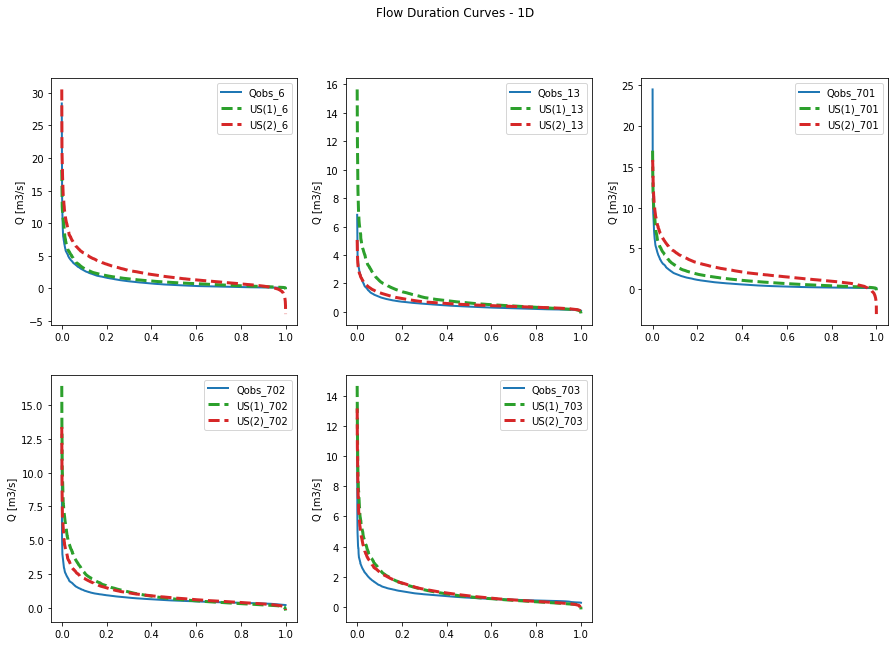

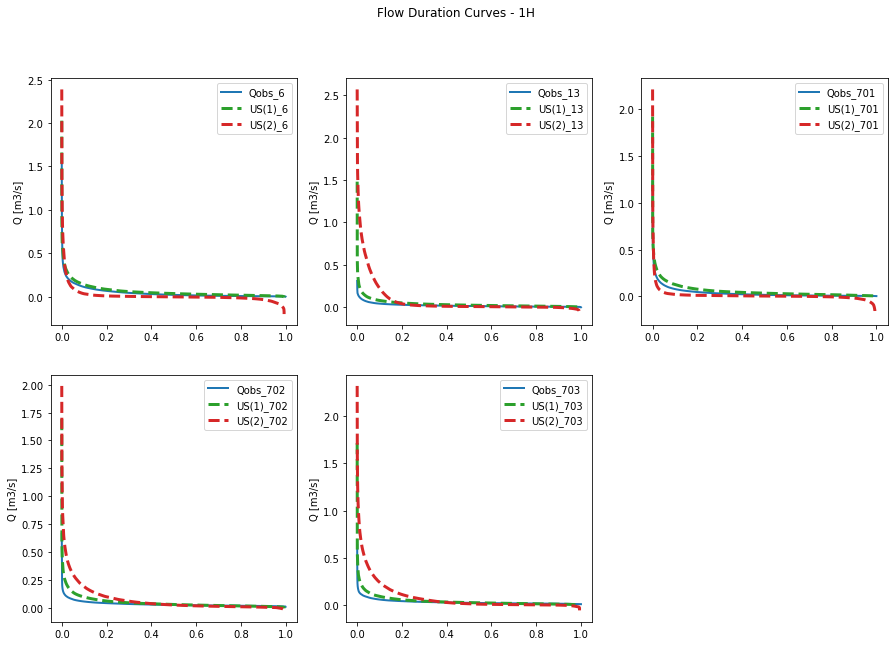

In [39]:
colors = [i for i in get_cmap('tab20b').colors]

for freq in frequencies:
    fig = plt.subplots(figsize=(15, 10))
    for i, catchm in enumerate(meuse_obs.catchments.values):

        if freq == '1D':
            meuse_obs = meuse_obs_d
#             wflow_sim = wflow_sim_d
        elif freq == '1H':
            meuse_obs = meuse_obs_h
#             wflow_sim = wflow_sim_h

        ax = plt.subplot(2, 3, i+1)
#         # get simulated streamflow
#         qsim = wflow_sim.sel(time=slice(start_date, end_date))
#         qsim = qsim.sel({'catchments':catchm}).\
#                 Qsim_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)
        
        # get observed streamflow
        qobs = meuse_obs.sel({'catchments':catchm}).\
                Qobs_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)

        

        # lstm sim no stats
        catchment = 'meuse_' + str(catchm)
        ds = nostat[catchment][freq]['xr']
        if freq == '1H':
            ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
            ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
            ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
        elif freq == '1D':
            ds = ds.isel(time_step = -1)
            ds = ds.drop('time_step')
            ds = ds.rename({'date': 'datetime'})
            ds = ds.sel(datetime=slice(start_date, end_date))
        qsim_ln = ds['qobs_sim'] * (24 if freq == '1D' else 1)

        # lstm sim less stats
        catchment = 'meuse_' + str(catchm)
        ds = lessstat[catchment][freq]['xr']
        if freq == '1H':
            ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
            ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
            ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
        elif freq == '1D':
            ds = ds.isel(time_step = -1)
            ds = ds.drop('time_step')
            ds = ds.rename({'date': 'datetime'})
            ds = ds.sel(datetime=slice(start_date, end_date))
        qsim_ll = ds['qobs_sim'] * (24 if freq == '1D' else 1)
        
        
        fdc = -np.sort(-qobs)
        x = np.linspace(0, 1, len(fdc))
        plt.plot(x, fdc, label=f'Qobs_{catchm}', color='C0', lw=2)

#         fdc = -np.sort(-qsim) 
#         x = np.linspace(0, 1, len(fdc))
#         plt.plot(x, fdc, label=f'Qsim_{catchm}', color='C1', lw=3) # color=colors[i*4]
  
        fdc = -np.sort(-qsim_ln)        
        x = np.linspace(0, 1, len(fdc))
        plt.plot(x, fdc, label=f'US(1)_{catchm}', color='C2', ls='--', lw=3)
        
        fdc = -np.sort(-qsim_ll)        
        x = np.linspace(0, 1, len(fdc))
        plt.plot(x, fdc, label=f'US(2)_{catchm}', color='C3', ls='--', lw=3)
        
#         plt.ylim(0, 1.2)
        plt.ylabel('Q [m3/s]')
        plt.legend()
    plt.suptitle(f'Flow Duration Curves - {freq}')

C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipyk

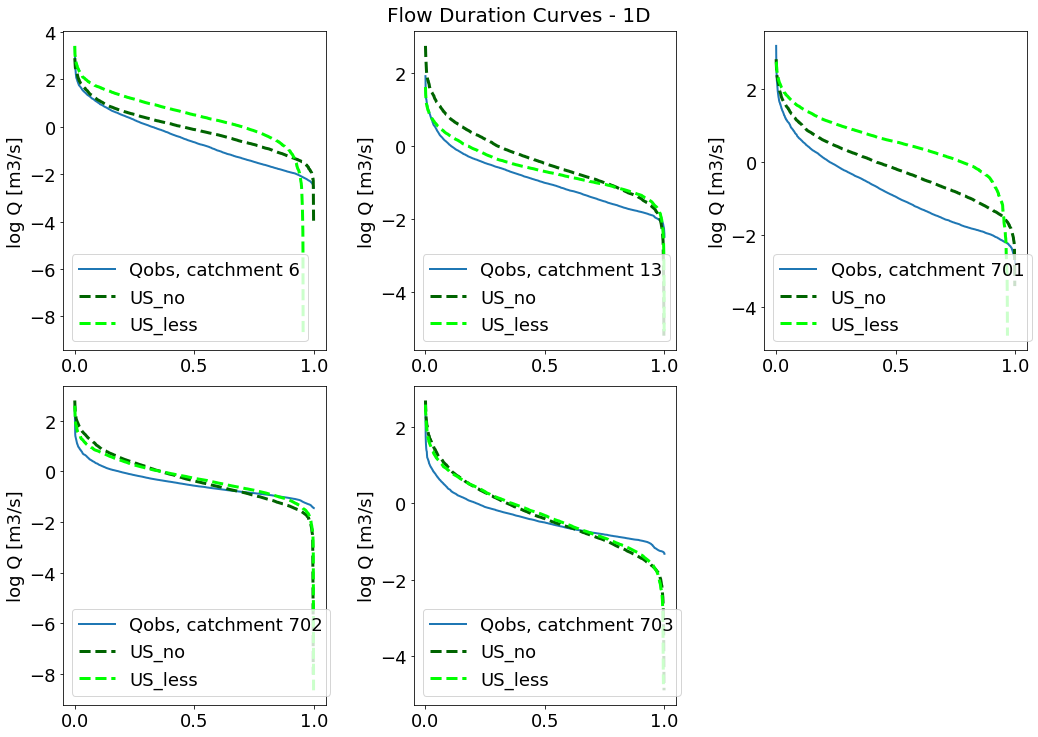

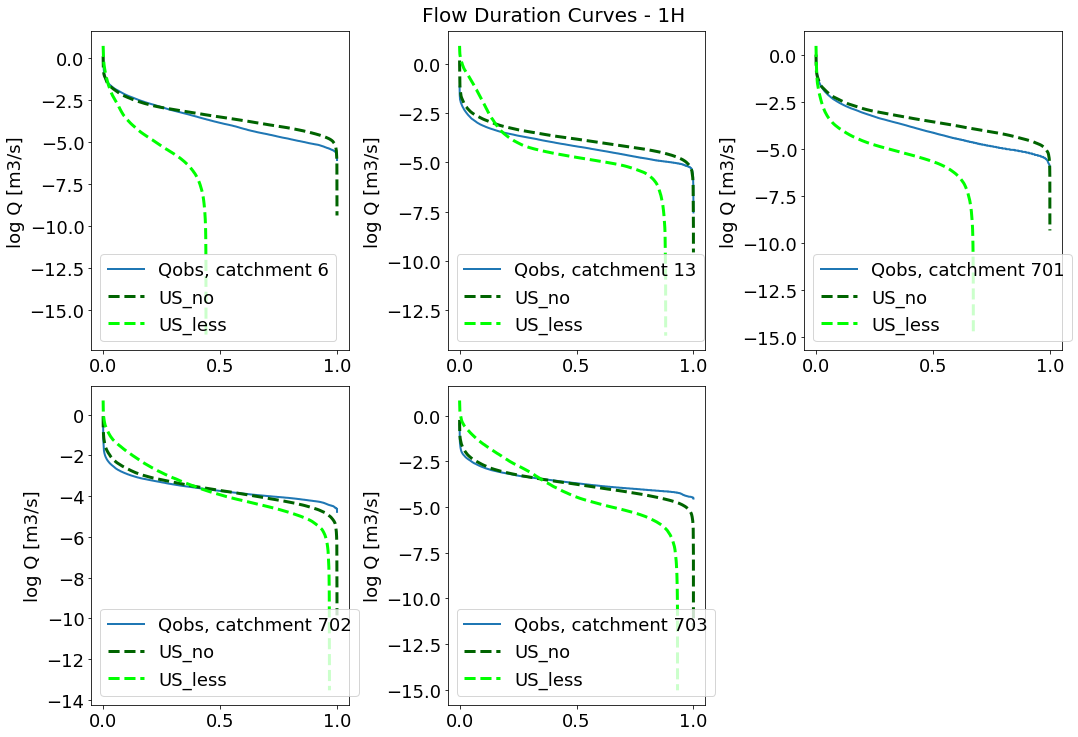

In [40]:
colors = [i for i in get_cmap('tab20b').colors]

for freq in frequencies:
    fig = plt.subplots(figsize=(15, 10))
    for i, catchm in enumerate(meuse_obs.catchments.values):

        if freq == '1D':
            meuse_obs = meuse_obs_d
#             wflow_sim = wflow_sim_d
        elif freq == '1H':
            meuse_obs = meuse_obs_h
#             wflow_sim = wflow_sim_h

        ax = plt.subplot(2, 3, i+1)
#        # get simulated streamflow
#         qsim = wflow_sim.sel(time=slice(start_date, end_date))
#         qsim = qsim.sel({'catchments':catchm}).\
#                 Qsim_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)
        
        # get observed streamflow
        qobs = meuse_obs.sel({'catchments':catchm}).\
                Qobs_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)

        

        # lstm sim no stats
        catchment = 'meuse_' + str(catchm)
        ds = nostat[catchment][freq]['xr']
        if freq == '1H':
            ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
            ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
            ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
            ds = ds.sel(datetime=slice(start_date, end_date))
        elif freq == '1D':
            ds = ds.isel(time_step = -1)
            ds = ds.drop('time_step')
            ds = ds.rename({'date': 'datetime'})
            ds = ds.sel(datetime=slice(start_date, end_date))
        qsim_ln = ds['qobs_sim'].values * (24 if freq == '1D' else 1)
        
        # lstm sim less stats
        catchment = 'meuse_' + str(catchm)
        ds = lessstat[catchment][freq]['xr']
        if freq == '1H':
            ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
            ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
            ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
            ds = ds.sel(datetime=slice(start_date, end_date))
        elif freq == '1D':
            ds = ds.isel(time_step = -1)
            ds = ds.drop('time_step')
            ds = ds.rename({'date': 'datetime'})
            ds = ds.sel(datetime=slice(start_date, end_date))
        qsim_ll = ds['qobs_sim'].values * (24 if freq == '1D' else 1)
        
        qsim_ln = np.where(qsim_ln < 0, 0, qsim_ln)
        qsim_ll = np.where(qsim_ll < 0, 0, qsim_ll)
        
        qobs_log = np.log(qobs)
        fdc = -np.sort(-qobs_log)
        x = np.linspace(0, 1, len(fdc))
        ax.plot(x, fdc, label=f'Qobs, catchment {catchm}', color='C0', lw=2)

#         qsim_log = np.log(qsim)
#         fdc = -np.sort(-qsim_log) 
#         x = np.linspace(0, 1, len(fdc))
#         ax.plot(x, fdc, label=f'Qsim_{catchm}', color='C1', lw=3)  

        qsim_ln_log = np.log(qsim_ln)
        fdc = -np.sort(-qsim_ln_log)        
        x = np.linspace(0, 1, len(fdc))
        ax.plot(x, fdc, label=f'US_no', color='darkgreen', ls='--', lw=3)
        
        qsim_ll_log = np.log(qsim_ll)
        fdc = -np.sort(-qsim_ll_log)        
        x = np.linspace(0, 1, len(fdc))
        ax.plot(x, fdc, label=f'US_less', color='lime', ls='--', lw=3)
        
        plt.ylabel('log Q [m3/s]',  fontsize=18)
        ax.tick_params('both', labelsize=18)
        plt.legend( fontsize=18)
    plt.tight_layout()
    plt.suptitle(f'Flow Duration Curves - {freq}', y=1.02, fontsize=20)